In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from numba.typed import List
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans
from scipy.integrate import cumtrapz

In [2]:
def step(tt):
    out = np.zeros_like(tt)
    out[tt >= 0] = 1
    return out

def ramp(tt):
    out = np.array(tt)
    out[tt < 0] = 0
    return out

def jitter(gain, omega, tt, t0, tf):
    out = np.array(tt)
    
    out = gain * np.sin(omega*(tt-t0))
    out[tt-t0 < 0] = 0
    out[tt-tf > 0] = 0
    return out

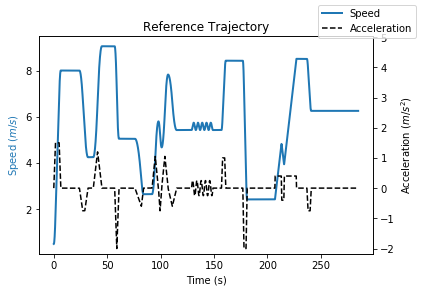

In [3]:
t0 = np.arange(3, 288, 0.01)
a0 = ramp(t0-3) - ramp(t0-4.5) - ramp(t0-8) + ramp(t0-9.5) \
    - 0.25*ramp(t0-27) + 0.25*ramp(t0-30) + 0.25*ramp(t0-32) - 0.25*ramp(t0-35) \
    + 0.3*ramp(t0-40) - 0.6*ramp(t0-44) + 0.3*ramp(t0-48) \
    - 1*ramp(t0-60) + 2*ramp(t0 - 62) - 1*ramp(t0-64) \
    - 0.1*ramp(t0-79) + 0.4*ramp(t0-85) - 0.3*ramp(t0-87) \
    + 0.35*ramp(t0-95) - 0.7*ramp(t0-98) + 0.35*ramp(t0-101) \
    - 0.5*ramp(t0-101) + 1*ramp(t0-102.5) - 0.5*ramp(t0-104) \
    + 0.35*ramp(t0-104) - 0.7*ramp(t0-107) + 0.35*ramp(t0-110) \
    - 0.15*ramp(t0-110) + 0.3*ramp(t0-114) - 0.15*ramp(t0-118) \
    + jitter(0.25, np.pi / 2.0, t0, 132, 152) \
    + 1.*ramp(t0-160) - 1.*ramp(t0-161) - 1.*ramp(t0-163) + 1.*ramp(t0-164) \
    - 2.*ramp(t0 - 180) + 2*ramp(t0-181) + 2 *ramp(t0-183) - 2*ramp(t0-184) \
    + 2.0 * ramp(t0-210) - 2.0*ramp(t0-210.2) - 2.0*ramp(t0-216) + 2.0*ramp(t0-216.4)\
    + 2.0 * ramp(t0-218.4) - 2.0*ramp(t0-218.8)  - 2.0*ramp(t0 - 230) + 2.0*ramp(t0-230.2) \
    - 0.75*ramp(t0-240) + 0.75*ramp(t0-241) + 0.75*ramp(t0-243) - 0.75*ramp(t0-244) #\
    #+ 5.0*step(t0-255) - 5.0*step(t0-256)
t0 = np.arange(0, 285, 0.01)
v0 = cumtrapz(a0, t0, initial=0.) + 0.5

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.plot(t0, v0, color='tab:blue', linewidth=2.0, label='Speed')
ax1.set_ylabel('Speed 'r'$(m/s)$', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(t0, a0, color='black', linestyle='--', linewidth=1.5, label='Acceleration')
ax2.set_ylabel('Acceleration '+r'$(m/s^2)$', color='black')
ax2.set_ylim(ax2.get_ylim()[0], 3 * ax2.get_ylim()[1])

fig.legend()
plt.title('Reference Trajectory')
plt.show()

# LOAD PARAMETER

In [4]:
# Steady State Response
param_ssr = np.load('model/steady_state/pso_best.npy')

# Dynamics
param_dynamics = np.load('model/system_history.npy')[-1]

In [5]:
print(param_ssr)
print(param_dynamics)

[ 0.95959429 -0.12973389 -0.15346456]
[-9.32977948e-01 -8.76899268e-01 -3.81319388e-06  2.33466279e+00
  5.20318838e+00  5.56628511e-02  2.09908015e-01 -5.62895447e-01
 -1.38426110e+01 -2.04113361e-01 -6.71627133e-01  8.60289954e-02
  1.36439056e+02  3.02852036e+01  8.87338285e+01  4.19427450e+01
 -3.10163967e-01]


In [6]:
# Steady state response parameters
beta1, beta2, beta3 = param_ssr

# System parameters
a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param_dynamics
td11 = int(np.around(td11))
td12 = int(np.around(td12))
td13 = int(np.around(td13))
td21 = int(np.around(td21))
td22 = int(np.around(td22))
td23 = int(np.around(td23))

In [7]:
print("Steady State response parameter ")
print("---------------------------------------------------------------------------------------")
print("Beta1 \t\t\t Beta2 \t\t\t Beta3")
print(beta1, "\t", beta2,"\t", beta3)
print("---------------------------------------------------------------------------------------")
print()
print("System parameter ")
print("---------------------------------------------------------------------------------------")
print("a1 \t\t\t a2 \t\t\t a3")
print(a1,"\t", a2,"\t", a3)
print("---------------------------------------------------------------------------------------")
print("b1 \t\t\t b2 \t\t\t b3 \t\t\t b4")
print(b1, "\t", b2, "\t", b3, "\t", b4)
print("---------------------------------------------------------------------------------------")
print("c1 \t\t\t c2 \t\t\t c3 \t\t\t c4")
print(c1, "\t", c2, "\t", c3, "\t", c4)
print("---------------------------------------------------------------------------------------")
print("td11 \t\t\t td12 \t\t\t td13 ")
print(td11, "\t\t\t", td12, "\t\t\t", td13)
print("---------------------------------------------------------------------------------------")
print("td21 \t\t\t td22 \t\t\t td23 ")
print(td21, "\t\t\t", td22, "\t\t\t", td23)
print("---------------------------------------------------------------------------------------")

Steady State response parameter 
---------------------------------------------------------------------------------------
Beta1 			 Beta2 			 Beta3
0.9595942883833863 	 -0.12973388797445237 	 -0.15346455867532907
---------------------------------------------------------------------------------------

System parameter 
---------------------------------------------------------------------------------------
a1 			 a2 			 a3
-0.932977948449612 	 -0.8768992676064652 	 -3.8131938805134536e-06
---------------------------------------------------------------------------------------
b1 			 b2 			 b3 			 b4
2.3346627915873586 	 5.203188381213886 	 0.05566285105151837 	 0.20990801535027429
---------------------------------------------------------------------------------------
c1 			 c2 			 c3 			 c4
-0.5628954470469816 	 -13.842610975471302 	 -0.20411336134481003 	 -0.6716271325263895
---------------------------------------------------------------------------------------
td11 			 td12 			 td13 
0 	

In [8]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2, 0.3]), 0)

In [9]:
@njit ("float64(float64, float64, float64)")
def clip(input_, min_, max_):
    if input_ > max_:
        return max_
    elif input_ < min_:
        return min_
    else:
        return input_
    
_ = clip(2.0, -1.0, 1.0)

In [55]:
@njit
def PID_Control(k, v, t, gain, min_, max_):
    # Initialize the constants
    kp, ki, kd = k
    PID = np.zeros(t.shape)
    
    dt = np.mean(t[1:] - t[:-1])
    ki = ki*dt
    kd = kd/dt
    e_sum_max = 1.0/ki
    
    err = 0.0
    e_sum = 0.0
    e_last = 0.0
    
    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0
    
    e_sum = e_sum + err*(t[1] - t[0])
    
    # PID Loop
    for i in range(t.shape[0]):
        sp = clip(v[i], 0.0, np.Inf)
        sr = clip(beta1 * (1.0 - np.exp(beta2*sp + beta3*sp**(0.1))), 0.0, 1.0)
        
        # Count the mean square error
        err = sp - y
        e_sum_max = (1.0 - sr) / ki        
        e_sum_max = max(e_sum_max, 0.0)
        e_sum += err
        e_sum = clip(e_sum, - e_sum_max, e_sum_max)
        
        # PID value set
        PID[i] = sr + kp*err + ki*e_sum + kd*(err - e_last)
        
        e_last = err
       
        '''if ((PID[i]<0 and err<0) or (PID[i]>0 and err>0) and (PID[i])>clip(PID[i], min_, max_)):
            e_sum = clip(e_sum, min_/ki, max_/ki)
            I_ = ki*e_sum'''
        
        # Range for control output
        u1 = clip(PID[i], 0.0, 1.0)
        u2 = clip(-PID[i], 0.0, 1.0)
        
        # DYNAMICS     
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t  \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out, u1_list, u2_list
_ = PID_Control(np.array([1.0,2.0,3.0]), np.ones(10), np.arange(10), 1.0, 0.0, 1.0)

In [127]:
@njit
def constrain(param):
    kp, ki, kd = param
    if (kp < 0 or ki < 0 or kd < 0):
        return False
    return True  
_ = constrain(np.array([0.5, 0.5, 0.5]))

In [111]:
@njit
def PSO(c_func, n_param, particles, lb, ub, iterate_max):
    # Define the constants
    w = 0.8
    w_max = 0.9
    w_min = 0.4
    c1 = 0.8
    c2 = 1.0
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.random.uniform(lb, ub, (particles, n_param))
    pbest_pos = ppos_vector
    pfit_value = np.ones(particles) * 1e100
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    pvel_vector = np.zeros((particles, n_param))
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
        
    # Second loop for implementing the PSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the velocity and position vector
            pvel_vector[i] = w*pvel_vector[i] + c1*random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*random.random()*(gbest_pos-ppos_vector[i])
            ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
            
            cost_func = c_func(ppos_vector[i])
            
            # Update each values using the cost functions
            if(pfit_value[i] > cost_func):
                pfit_value[i] = cost_func
                pbest_pos[i] = np.copy(ppos_vector[i])
                
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
    
    gbest_loss = c_func(gbest_pos)
    
    print(gbest_loss)
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return gbest_pos, gbest_loss

_ = PSO(calculate_total_cost, 3, 1, 0.0, 1.0, 1)

Iteration:  1  | Global best cost:  0.028456277502936007
0.028456277502936007
The best position for each parameter:  [0.76281013 0.26058223 0.06110277]  with  1  iteration.


In [129]:
@njit
def APSO(c_func, n_param, particles, lb, ub, iterate_max):
    # Define the constants
    alpha0 = 0.5
    beta = 0.5
    gamma = 0.9
    iterate = 0
    
    # Setup the initial conditions for position and velocity arrays
    ppos_vector = np.random.uniform(lb, ub, (particles, n_param))
    gbest_pos = np.zeros(n_param)
    gfit_value = 1e100
    
    # First loop for assigning the fitness value using the cost function
    for i in range(particles):
        # Check the position of individual and group value using the evaluation function
        cost_func = c_func(ppos_vector[i])
        
        # Update the global value using the cost functions
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
            
    # Second loop for implementing the APSO Algorithm
    while (iterate < iterate_max):
        for i in range(particles):
            # Update the alpha value
            alpha = alpha0*gamma**iterate
            
            # Update the velocity and position vector
            ppos_vector[i] = (1-beta)*ppos_vector[i] + alpha*np.random.normal(0,1) + beta*gbest_pos
            
            cost_func = c_func(ppos_vector[i])
            
            # Update the global value using the cost functions
            if(gfit_value > cost_func):
                gfit_value = cost_func
                gbest_pos = np.copy(ppos_vector[i])
        
        iterate = iterate+1
        print("Iteration: ", iterate, " | Global best cost: ", c_func(gbest_pos))
   
    gbest_loss = c_func(gbest_pos)
    
    print(gbest_loss)
    print("The best position for each parameter: ", gbest_pos, " with ", iterate, " iteration.")
    return gbest_pos, gbest_loss

_ = APSO(calculate_total_cost, 3, 1, 0.0, 1.0, 1)

Iteration:  1  | Global best cost:  0.49982791061757514
0.49982791061757514
The best position for each parameter:  [0.18405916 0.04169399 0.19392712]  with  1  iteration.


In [118]:
def cluster_center(clust, c_func):
    ranked = np.zeros([clust.shape[0], clust.shape[1] + 1])
    
    for i in range(clust.shape[0]):
        for j in range(clust.shape[1]):
            ranked[i][j] = clust[i][j]
        ranked[i][j+1] = c_func(clust[i])
    
    ranked = np.delete(ranked[ranked[:,-1].argsort()], -1, axis=1)
    
    return ranked[0]

In [119]:
def logsig(x):
    return 1 / (1 + math.exp(-x))

In [141]:
def BSO(c_func, n_param, n_ideas, lb, ub, max_iterate):
    # Define initial parameters
    ideas = np.random.uniform(lb, ub, (n_ideas, n_param))
    Km = KMeans(n_clusters=3, max_iter=100)
    iterate = 0
    k = 20
    new_ideas = np.zeros([n_ideas, n_param])
    
    # Define the probabilities
    p_one = 0.5
    p_one_center = 0.7
    p_two_center = 0.7
    
    # Main BSO Loop
    while(iterate < max_iterate):
        print("Clusterizing", end="")
        
        # Clusterize the ideas
        print(".",end="")
        cluster = Km.fit_predict(ideas)
        cl1 = ideas[cluster == 0]
        cl2 = ideas[cluster == 1]
        cl3 = ideas[cluster == 2]
        clusters = [cl1, cl2, cl3]
        print(".", end="")
        
        # Generate n new ideas
        for i in range(ideas.shape[0]):
            # New idea based on one cluster
            if np.random.random() < p_one:
                cl_selected = random.choice(clusters)
                cl_selected_center = cluster_center(cl_selected,  c_func)
                
                # Use the previous cluster center
                if np.random.random() < p_one_center:
                    new_ideas[i] = cl_selected_center
                
                # Use random idea in a cluster
                else:
                    new_ideas[i] = random.choice(cl_selected)
            
            # New idea based on two cluster
            else:
                cl_selected1, cl_selected2 = random.sample(clusters, 2)
                cl_selected_center1 = cluster_center(cl_selected1, c_func)
                cl_selected_center2 = cluster_center(cl_selected2, c_func)
                rand = np.random.random()
                
                # Use the combination of two previous cluster centers
                if np.random.random() < p_two_center:
                    new_ideas[i] = rand*cl_selected_center1 + (1-rand)*cl_selected_center2
                    
                # Use two random ideas in a cluster
                else:
                    new_ideas[i] = rand*random.choice(cl_selected1) + (1-rand)*random.choice(cl_selected2)
            
            eps = logsig((0.5*max_iterate - iterate)/k)
            upd_new_ideas = np.copy(new_ideas[i]) + eps*np.random.normal(0, 1)
            
            if(c_func(upd_new_ideas) < c_func(new_ideas[i])):
                new_ideas[i] = upd_new_ideas
        
        print(". Ideas Generated!",end="")
        
        ideas = new_ideas
        iterate = iterate + 1
        print(" | Iteration: ", iterate)
    
    # Reclusterize ideas
    print("Clusterizing")
    cluster = Km.fit_predict(ideas)
    cl1 = ideas[cluster == 0]
    cl2 = ideas[cluster == 1]
    cl3 = ideas[cluster == 2]
    clusters = np.array([cl1, cl2, cl3])
    
    # Choose the best cluster center for the output
    for i in range(clusters.shape[0]):
        cl1_center = cluster_center(cl1, c_func)
        cl2_center = cluster_center(cl2, c_func)
        cl3_center = cluster_center(cl3, c_func)
    
    possible_ideas = np.array([cl1_center, cl2_center, cl3_center])
    idea_out = cluster_center(possible_ideas, c_func)
    idea_loss = c_func(idea_out)
    
    print("The best idea is ", idea_out, " with a cost of ", idea_loss)
    
    return idea_out, idea_loss

_ = BSO(calculate_total_cost, 3, 25, 0.0, 1.0, 1)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing
The best idea is  [0.72166744 0.54005026 0.0754118 ]  with a cost of  0.018744954248814075


In [28]:
@njit
def gradient(a, t):
    forward = np.zeros_like(a)
    forward[:-1] = a[1:]
    forward[-1] = forward[-2]
    backward = np.zeros_like(a)
    backward[1:] = a[:-1]
    backward[0] = backward[1]
    
    dt = np.mean(t[1:]-t[:-1])
    out = (forward - backward) / 2 / dt
    return out
_ = gradient(v0, t0)

In [29]:
idx = np.array([[9.5, 27.], [35., 40.], [48., 60.], [64., 79.], [87., 95.], [118., 132.], [164., 180.], [184., 210.], [230.2, 240.], [244., t0[-1]+3.]]) -3
direction = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

@njit
def max_os_sim(mv):
    out = 0.
    for i in range(mv.shape[0]):
        for j in range(idx.shape[0]):
            if idx[j,0] <= t0[i] and t0[i] <= idx[j,1]:
                if direction[j] > 0.5:
                    temp = mv[i] - v0[i]
                else:
                    temp = v0[i] - mv[i]
                temp = temp / v0[i] * 100
                temp = clip(temp, 0.0, np.Inf)
                if temp > out:
                    out = temp
    return out
_ = max_os_sim(np.zeros(v0.shape[0]))

In [92]:
@njit
def cost(t, v, param, sp_gain, lamda):
    M = 0
    loss = 0
    for i in range(sp_gain.shape[0]):
        
        mv, cs1, cs2 = PID_Control(param, v, t, sp_gain[i], 0.0, 1.0)
        ma = gradient(mv, t)
        mj = gradient(ma, t)

        error = v - mv
        max_os = max_os_sim(mv)
        if max_os > lamda[1]: # max_os %
            if sp_gain[i] == 1.0:
                return np.Inf
        loss += np.sum(np.abs(error)) + lamda[0] * np.sum(np.abs(mj))
        M += t.shape[0]
    return loss / M
_ = cost(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]), np.ones(3), np.array([0.001, 0.001]))

In [31]:
@njit
def mean_squared_error(t, v, param):
    mv, _, _ = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    error = v - mv
    cost = np.mean(error**2)
    return cost
_ = mean_squared_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_error(t, v, param):
    mv, _, _ = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    error = v - mv
    out = np.mean(np.abs(error))
    return out
_ = mean_absolute_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def max_absolute_error(t, v, param):
    mv, _, _ = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    error = v - mv
    return np.max(np.abs(error))
_ = max_absolute_error(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_jerk(t, v, param):
    mv, _, _ = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    
    ma = gradient(mv, t)
    mj = gradient(ma, t)
    return np.mean(np.abs(mj))
_ = mean_absolute_jerk(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_squared_jerk(t, v, param):
    mv, _, _ = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    
    ma = gradient(mv, t)
    mj = gradient(ma, t)
    return np.mean(mj**2)
_ = mean_squared_jerk(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def max_percent_overshoot(t, v, param):
    mv, _, _ = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    return max_os_sim(mv)
_ = max_percent_overshoot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_absolute_u_dot(t, v, param):
    mv, cs1, cs2 = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    
    cs1_dot = gradient(cs1, t)
    cs2_dot = gradient(cs2, t)
    return np.mean(np.abs(cs1_dot)+np.abs(cs2_dot))
_ = mean_absolute_u_dot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

@njit
def mean_squared_u_dot(t, v, param):
    mv, cs1, cs2 = PID_Control(param, v, t, 1.0, 0.0, 5.0)
    
    cs1_dot = gradient(cs1, t)
    cs2_dot = gradient(cs2, t)
    return np.mean(np.abs(cs1_dot)**2+np.abs(cs2_dot)**2)
_ = mean_squared_u_dot(np.arange(10, dtype=float), np.ones(10), np.array([0.1, 0.1, 0.1]))

In [101]:
@njit
def calculate_total_cost(param):
    sp_gain = np.array([1.0])
    lamda = np.array([0.0, 15.0])
    if constrain(param):
        return cost(t0, v0, param, sp_gain, lamda)
    else:
        return np.Inf
_ = calculate_total_cost(np.array([0.1, 0.1, 0.1]))

In [138]:
pso_best, pso_loss = PSO(calculate_total_cost, 3, 25, 0.01, 1.0, 1000)

Iteration:  1  | Global best cost:  0.016862531414992405
Iteration:  2  | Global best cost:  0.016862531414992405
Iteration:  3  | Global best cost:  0.016862531414992405
Iteration:  4  | Global best cost:  0.016862531414992405
Iteration:  5  | Global best cost:  0.016862531414992405
Iteration:  6  | Global best cost:  0.016724608105722544
Iteration:  7  | Global best cost:  0.016617915080452794
Iteration:  8  | Global best cost:  0.016607769707989373
Iteration:  9  | Global best cost:  0.016607769707989373
Iteration:  10  | Global best cost:  0.016607769707989373
Iteration:  11  | Global best cost:  0.01637132546745443
Iteration:  12  | Global best cost:  0.01637132546745443
Iteration:  13  | Global best cost:  0.015886701233409267
Iteration:  14  | Global best cost:  0.015886701233409267
Iteration:  15  | Global best cost:  0.015328601402251276
Iteration:  16  | Global best cost:  0.015328601402251276
Iteration:  17  | Global best cost:  0.015328601402251276
Iteration:  18  | Global 

In [139]:
apso_best, apso_loss = APSO(calculate_total_cost, 3, 25, 0.01, 1.0, 1000)

Iteration:  1  | Global best cost:  0.07379938084301634
Iteration:  2  | Global best cost:  0.022904101047509867
Iteration:  3  | Global best cost:  0.022858381599387596
Iteration:  4  | Global best cost:  0.022858381599387596
Iteration:  5  | Global best cost:  0.022858381599387596
Iteration:  6  | Global best cost:  0.022858381599387596
Iteration:  7  | Global best cost:  0.022858381599387596
Iteration:  8  | Global best cost:  0.022858381599387596
Iteration:  9  | Global best cost:  0.022858381599387596
Iteration:  10  | Global best cost:  0.022858381599387596
Iteration:  11  | Global best cost:  0.022858381599387596
Iteration:  12  | Global best cost:  0.022765821083400004
Iteration:  13  | Global best cost:  0.022765821083400004
Iteration:  14  | Global best cost:  0.022765821083400004
Iteration:  15  | Global best cost:  0.022765821083400004
Iteration:  16  | Global best cost:  0.022765821083400004
Iteration:  17  | Global best cost:  0.022765821083400004
Iteration:  18  | Global

In [146]:
bso_best, bso_loss = BSO(calculate_total_cost, 3, 25, 0.01, 1.0, 200)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

In [102]:
calculate_total_cost(np.array([0.56458294, 2.25339951, 0.07817718]))

0.010105889364780265

In [41]:
print("w = dynamic, c1 = 0.8, c2 = 1.0")
print("15 particle, 100 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t\t Kd \t\t\t cost")
print("2.38188758e-01 \t 1.03883161e-04 \t 2.30210850e-01 \t 0.982669420151786")
print("----------------------------------------------------------------------")

w = dynamic, c1 = 0.8, c2 = 1.0
15 particle, 100 iteration
----------------------------------------------------------------------
Kp 		 Ki 			 Kd 			 cost
2.38188758e-01 	 1.03883161e-04 	 2.30210850e-01 	 0.982669420151786
----------------------------------------------------------------------


In [38]:
print("w = dynamic, c1 = 0.8, c2 = 1.0")
print("20 particle, 100 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("4.75149501 \t -0.99861601 \t 3.43378999 \t 0.9395455593976628")-++cf28                
print("----------------------------------------------------------------------")

w = dynamic, c1 = 0.8, c2 = 1.0
20 particle, 100 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
4.75149501 	 -0.99861601 	 3.43378999 	 0.9395455593976628
----------------------------------------------------------------------


In [18]:
print("w = 0.5, c1 = 0.8, c2 = 0.7")
print("50 particle, 500 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("0.69825959 \t 0.00156853 \t 0.44029915 \t 0.9656800888210394")
print("----------------------------------------------------------------------")

w = 0.5, c1 = 0.8, c2 = 0.7
50 particle, 500 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
0.69825959 	 0.00156853 	 0.44029915 	 0.9656800888210394
----------------------------------------------------------------------


In [55]:
print("w = 0.5, c1 = 0.8, c2 = 0.7")
print("50 particle, 300 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("0.80570659 \t 0.00179049 \t 0.49065543 \t 0.9656888015701284")
print("----------------------------------------------------------------------")

w = 0.5, c1 = 0.8, c2 = 0.7
50 particle, 300 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
0.80570659 	 0.00179049 	 0.49065543 	 0.9656888015701284
----------------------------------------------------------------------


In [19]:
print("w = 0.7, c1 = 0.6, c2 = 0.9")
print("50 particle, 500 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("5.11409037 \t -1.94695496 \t 3.47297359 \t 0.9665758271310273")
print("----------------------------------------------------------------------")

w = 0.7, c1 = 0.6, c2 = 0.9
50 particle, 500 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
5.11409037 	 -1.94695496 	 3.47297359 	 0.9665758271310273
----------------------------------------------------------------------


In [52]:
pp, gp = idea

In [34]:
import matplotlib.pyplot as plt
plt.hist(pp[:,0], label=('Kp'))
plt.hist(pp[:,1], label=('Ki'))
plt.hist(pp[:,2], label=('Kd'))
         
plt.ylabel("N-Particles")
plt.ylim(0,1)
plt.xlabel("Kp, Ki, Kd")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

NameError: name 'pp' is not defined

In [54]:
pp

array([[0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.69825959, 0.00156853, 0.44029915],
       [0.